In [1]:
import csv
import argparse
import nibabel as nib
import numpy as np
from nilearn import input_data, image
import pandas as pd

data_dir='/data/mounts/scs-fs-20/kpsy/genr/mrdata/GenR_MRI/bids/derivatives/fmriprep/sub-1045/ses-F09/func'
despike_dir='/data/mounts/scs-fs-20/kpsy/genr/users/jflournoy/GenR_motion/sub-1045/ses-F09/func'
inputimg=nib.load(despike_dir + '/' + 'sub-1045_ses-F09_task-rest_acq-0006_run-0000_space-MNI152NLin2009cAsym_desc-despike_bold.nii.gz')
inputmask=nib.load(data_dir + '/' + 'sub-1045_ses-F09_task-rest_acq-0006_run-0000_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz')
confoundsfile=data_dir + '/' + 'sub-1045_ses-F09_task-rest_acq-0006_run-0000_desc-confounds_regressors.tsv'
inputtr=0
conftype="36P"
spikethr=0.5
smoothkern=5.0
drop_first=5

In [2]:
def get_spikereg_confounds(motion_ts, dvars, fd_threshold, dvars_threshold=None):
    """
    motion_ts = [0.1, 0.7, 0.2, 0.6, 0.3]
    dvars = [.2, .3, .5, .7, 20]
    fd_threshold = 0.5
    dvars_threshold=None
    get_spikereg_confounds(motion_ts, dvars, fd_threshold, dvars_threshold)

    returns
    1.) a df with spikereg confound regressors (trs with motion > thershold)
       outlier_1  outlier_2  outlier_3
     0          0          0          0
     1          1          0          0
     2          0          0          0
     3          0          1          0
     4          0          0          1

    2.) a df with counts of outlier and non-outlier trs
                value          
              outliers clean_trs
     variable                   
     dvars         1.0       4.0
     fd            2.0       3.0
     total         3.0       2.0
    
    note, from Ciric et. al, "the conversion of FD to RMS displacement is approximately 2:1"...
    -> here we are using FD for spike thr, so a value of 0.5 is ~ to the 0.25mm RMS spike thr of 36P method

    """
    df = pd.DataFrame({"motion": motion_ts,
                       "dvars": dvars})
    df.fillna(value=0, inplace=True)  # first value is nan
    if dvars_threshold is None:
        q75, q25 = np.percentile(df.dvars, q=[75 ,25])
        iqr = q75 - q25
        dvars_threshold = q75 + 1.5*iqr
    df["fd_outlier"] = df["motion"] > fd_threshold
    df["dvars_outlier"] = df["dvars"] > dvars_threshold
    df["outlier"] = np.ceil((df["fd_outlier"].astype(int) + df["dvars_outlier"].astype(int)) / 2)
    outlier_type_names = {"fd_outlier": "fd", "dvars_outlier": "dvars", "outlier": "total"}
    agg_names = {"sum": "outliers","<lambda>": "clean_trs"}
    outlier_stats = df[["fd_outlier", "dvars_outlier", "outlier"]].rename(columns=outlier_type_names).melt().groupby("variable").agg({'value': [np.sum, lambda values: np.sum(-(values-1))]}).rename(columns=agg_names)
    df["outliers_num"] = 0
    df.loc[df.outlier == 1, "outliers_num"] = range(1, df.outlier.astype(int).sum() + 1)
    outliers = pd.get_dummies(df.outliers_num, dtype=int, drop_first=True, prefix="outlier")
    
    outlier_stats.columns = outlier_stats.columns.droplevel()
    outlier_stats.reset_index(inplace=True)
    return outliers, outlier_stats


def get_confounds(confounds_file, kind="36P", spikereg_fd_threshold=None, spikereg_dvars_threshold=None):
    """
    takes a fmriprep confounds file and creates data frame with regressors.
    kind == "36P" returns Satterthwaite's 36P confound regressors
    kind == "9P" returns CSF, WM, Global signal + 6 motion parameters (used in 
            Ng et al., 2016)
    kind == "aCompCor"* returns model no. 11 from Parkes
    kind == "24aCompCor"* returns model no. 7 from Parkes
    kind == "24aCompCorGsr"* returns model no. 9 from Parkes

    * fmriprep only provides 5 components overall... not sure if its exactly
    the same as in the paper, as they mention 5 from wm, 5 from csf

    if spikereg_fd_threshold=None, no spike regression is performed

    Satterthwaite, T. D., Elliott, M. A., Gerraty, R. T., Ruparel, K., 
    Loughead, J., Calkins, M. E., et al. (2013). An improved framework for 
    confound regression and filtering for control of motion artifact in the 
    preprocessing of resting-state functional connectivity data. NeuroImage, 
    64, 240?256. http://doi.org/10.1016/j.neuroimage.2012.08.052

    Parkes, L., Fulcher, B., Yücel, M., & Fornito, A. (2018). An evaluation
    of the efficacy, reliability, and sensitivity of motion correction
    strategies for resting-state functional MRI. NeuroImage, 171, 415-436.

    Ng et al. (2016). http://doi.org/10.1016/j.neuroimage.2016.03.029
    """
    if kind not in ["36P", "9P", "6P", "aCompCor", "24aCompCor", "24aCompCorGsr"]:
        raise Exception("Confound type unknown {}".format(kind))

    df = pd.read_csv(confounds_file, sep="\t")

    # extract nusiance regressors for movement + signal
    p6 = df[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
    p9 = df[['csf', 'white_matter', 'global_signal', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
    
    # 6Pder
    p6_der = p6.diff().fillna(0)
    p6_der.columns = [c + "_der" for c in p6_der.columns]
    
    # 9Pder
    p9_der = p9.diff().fillna(0)
    p9_der.columns = [c + "_der" for c in p9_der.columns]
    
    # 12P
    p12 = pd.concat((p6, p6_der), axis=1)
    p12_2 = p12 ** 2
    p12_2.columns = [c + "_2" for c in p12_2.columns]
    
    # 18P + 18P^2
    p18 = pd.concat((p9, p9_der), axis=1)
    p18_2 = p18 ** 2
    p18_2.columns = [c + "_2" for c in p18_2.columns]
    
    # 36P
    p36 = pd.concat((p18, p18_2), axis=1)

    # GSR4
    gsr = df['global_signal']
    gsr_der = gsr.diff().fillna(0)
    gsr_der2 = gsr_der ** 2
    gsr4 = pd.concat((gsr, gsr_der, gsr_der2), axis=1)
    gsr4['sqrterm'] = np.power(range(1, gsr.shape[0]+1), 2)

    # get compcor nuisance regressors and combine with 12P
    aCompC = df.filter(regex='a_comp_cor_')
    p12aCompC = pd.concat((p12, aCompC), axis=1)
    p24aCompC = pd.concat((p12, p12_2, aCompC), axis=1)

    if kind == "36P":
        confounds = p36
    elif kind == "9P":
        confounds = p9
    elif kind == "6P":
        confounds = p6
    elif kind == "aCompCor":
        confounds = p12aCompC
    elif kind == "24aCompCor":
        confounds = p24aCompC
    elif kind == "24aCompCorGsr":
        confounds = pd.concat((p24aCompC, gsr4), axis=1)
    else:
        # it will never get here, but assign confounds so my linter doesn't complain
        confounds = ''
        exit(1)

    if spikereg_fd_threshold:
        fd_threshold = spikereg_fd_threshold
        dvars_threshold = spikereg_dvars_threshold
    else:
        # if no spike regression still call get_spikereg_confounds to get count
        # of available trs
        fd_threshold = 99999
        dvars_threshold = 99999
    outliers, outlier_stats = get_spikereg_confounds(df["framewise_displacement"].values,
                                                     df["dvars"].values,
                                                     fd_threshold, dvars_threshold)

    if spikereg_fd_threshold:
        confounds = pd.concat([confounds, outliers], axis=1)

    return confounds, outlier_stats

In [8]:

# def nuisance_regress(inputimg, inputmask, confoundsfile, inputtr=0,
#     conftype="36P", spikethr=0.25, smoothkern=6.0):
"""

returns a nibabel.nifti1.Nifti1Image that is cleaned in following ways:
    detrending, smoothed, motion parameter regress, spike regress, 
    bandpass filtered, and normalized

options for motion paramter regress: 36P, 9P, 6P, or aCompCor

signal cleaning params from:

    Parkes, L., Fulcher, B., Yücel, M., & Fornito, A. (2018). An evaluation 
    of the efficacy, reliability, and sensitivity of motion correction 
    strategies for resting-state functional MRI. NeuroImage, 171, 415-436.

    Ciric, R., Wolf, D. H., Power, J. D., Roalf, D. R., Baum, G. L., 
    Ruparel, K., ... & Gur, R. C. (2017). Benchmarking of participant-level
    confound regression strategies for the control of motion artifact in 
    studies of functional connectivity. Neuroimage, 154, 174-187.

"""

# extract confounds
confounds, outlier_stats = get_confounds(confoundsfile,
                                         kind=conftype,
                                         spikereg_fd_threshold=spikethr)

if inputtr == 0:
    # read the tr from the fourth dimension of zooms, this depends on the input
    # data being formatted to have the dim4 be the TR...
    tr = inputimg.header.get_zooms()[3]
    print("found that tr is: {}".format(str(tr)))

    if tr == 0:
        print("thats not a good tr. exiting")
        exit(1)

else:
    tr = inputtr

#create 4D sample mask to exclude the first `drop_first` volumes
total_volumes = inputimg.shape[3]
sample_mask = [False] * drop_first + [True] * (total_volumes - drop_first)
print("total volumes: {}, dropping first {}".format(str(total_volumes), str(drop_first)))

found that tr is: 1.76
total volumes: 200, dropping first 5


In [9]:
# masker params
masker_params = {"mask_img": inputmask, "detrend": True, "standardize": True,
                 "low_pass": 0.08, "high_pass": 0.01, "t_r": tr,
                 "smoothing_fwhm": smoothkern, "verbose": 1, "sample_mask": sample_mask}
# invoke masker
masker = input_data.NiftiMasker(**masker_params)

# perform the nuisance regression
time_series = masker.fit_transform(inputimg, confounds=confounds.loc[sample_mask,].values)

# inverse masker operation to get the nifti object, n.b. this returns a Nifti1Image!!!
outImg = masker.inverse_transform(time_series)

# return outImg4, confounds, outlier_stats

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/data/mounts/scs-fs-20/kpsy/genr/users/jflournoy/GenR_motion/sub-1045/ses-F09/func/sub-1045_ses-F09_task-rest_acq-0006_run-0000_space-MNI152NLin2009cAsym_desc-despike_bold.nii.gz')
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


In [10]:
from nilearn import datasets

dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

print('Atlas ROIs are located in nifti image (4D) at: %s' %
      atlas_filename)  # 4D data

# One subject of resting-state data
#data = datasets.fetch_adhd(n_subjects=1)
#fmri_filenames = data.func[0]

Atlas ROIs are located in nifti image (4D) at: /home/jflournoy/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz


In [11]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                           memory='nilearn_cache', verbose=5)

# Here we go from nifti files to the signal time series in a numpy
# array. Note how we give confounds to be regressed out during signal
# extraction
time_series = masker.fit_transform(outImg)

[NiftiLabelsMasker.fit_transform] loading data from /home/jflournoy/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f88e2cdbe80>, <nilearn.input_data.nifti_labels_masker._ExtractionFunctor object at 0x7f88e3ee0588>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'labels_img': '/home/jflournoy/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_level=1, verbose=5)
[NiftiLabelsMasker.transform_single_imgs] Loading dat

/home/jflournoy/anaconda3/lib/python3.7/site-packages/nilearn/input_data/nifti_labels_masker.py:269: UserWarning: Persisting input arguments took 0.61s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


In [12]:
time_series

array([[ 0.5140484 ,  0.4836657 , -0.46259066, ...,  1.0501187 ,
        -0.6379449 , -0.29795212],
       [ 0.27809453,  0.11213405, -0.8437967 , ...,  0.8743001 ,
        -0.10457344, -0.15561995],
       [-0.00164236,  0.1419897 , -0.5914654 , ...,  0.79369247,
        -0.12450381, -0.13008215],
       ...,
       [-0.3309833 , -1.5412284 ,  1.1171917 , ..., -0.9001521 ,
         0.69854784,  0.15914892],
       [-0.53902704, -1.2703485 ,  1.1737145 , ..., -0.7314227 ,
         0.80562055,  0.04496174],
       [-0.49220726, -0.5466733 ,  0.54827404, ..., -0.83182216,
         0.6745166 , -0.47350958]], dtype=float32)

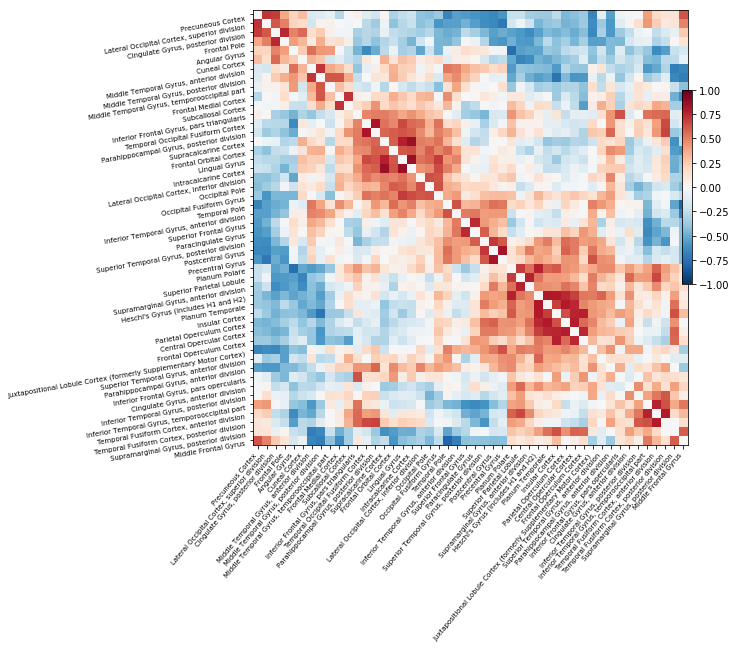

In [13]:
from nilearn.connectome import ConnectivityMeasure
import numpy as np
from nilearn import plotting
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
# Plot the correlation matrix
%matplotlib inline
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels[1:],
                     vmax=1, vmin=-1, reorder=True)